# Ready

In [ ]:
!pip install langchain-huggingface
!pip install langchain_community
!pip install pypdf

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer,pipeline
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
import torch
import pprint
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

model_name = "mixedbread-ai/mxbai-embed-large-v1"
hf_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
)
texts = ["National Central University\nDepartment of Computer Science & Information Engineering\nMaster Thesis" ,"tems. Recent research emphasizes that a proficient XAI method should adhere to a set"]
embeding = hf_embeddings.embed_documents(texts)

In [5]:

#document
loader   = PyPDFLoader("./Efficient K-Nearest Neighbor Graph Construction for Generic Similarity Measures.pdf")
documrnt  = loader.load()

#splitter
text_splitter = RecursiveCharacterTextSplitter( chunk_size = 250 , chunk_overlap = 20 )

# do split
document = text_splitter.split_documents(documrnt)


In [6]:
len(document)

220

# KNNG

In [8]:
import math
import random
import numpy as np
import heapq
# we need a class of node and edge for our K-nearest neighbor graph algorithm .
# Our data type is text for NLP task.
class Node :
  def __init__(self , id  , content : str  , vector : np.ndarray ) :
    self.content       = content
    self.vector       = vector
    self.id         = id

    self.out_edge      = []  # neighbors .

    self.old_edge      = [] # old neighbors .
    self.old_reverse_edge  = [] # old reverse neighbors .

    self.new_edge      = [] # new neighbors .
    self.new_reverse_edge  = [] # new reverseneighbors .



  def add_edge(self , edge ):

    if edge.from_node == self.id:
      self.out_edge.append(edge)
    elif edge.to_node == self.id:
      self.in_edge.append(edge)
    else:
      print(f"node :{self.id} has an error for add_edge function . ")

  def __repr__(self):
    return f"id: {self.id} , content :{self.content} , vector len :{len(self.vector)}"

class Edge :
  #Edge is used to record situation about connecting each node and the distance between the two nodes .
  def __init__(self , from_node :int , to_node:int , distance : float  , flag:bool = True) :
    self.from_node = from_node
    self.to_node  = to_node
    self.distance  = distance
    self.flag    = flag
  def __repr__(self ):

    return f"from:{self.from_node} to : {self.to_node} and distance :{self.distance} and flag :{self.flag}"

  def __lt__(self , other):
    return self.distance < other.distance



In [9]:
import copy
class KNNG_Builder():
  def __init__(self , document : list , embedding_model , k = 15 , p = 0.5  , l = 0.001) :
    self.embedding_model = embedding_model
    self.documents   = document
    self.B      = self.__Build_Node_Dictionary__() # Node dictionary

    self.k      = k
    self.p      = p
    self.l      = l
    self.n      = len(self.B)
    #Starting Build
    self.build_KNNG()

  def __Build_Node_Dictionary__(self) -> list:
    # according to length of contents, we execute a for loop to process contents .

    contents = []
    for ( index , item ) in enumerate(self.documents)  :
      contents.append (item.page_content)

    #get vecter by embedding model
    vecters = self.embedding_model.embed_documents( contents )

    #build node
    B ={}
    for ( index , content ) in enumerate(contents)  :
      node   = Node( index, content , vecters[index] )
      #新增key-value
      B[index] = node
    return B


  def __Cosine_Similarity__( self , vec1 , vec2 ) -> float:
    #we utilize cosine similarity to calculate the distance for two nodes of NLP task .
    dot_product = np.dot(vec1 , vec2 )
    norm_1   = np.linalg.norm(vec1)
    norm_2   = np.linalg.norm(vec2)
    similarity = dot_product / (norm_1 * norm_2)
    return similarity

  def __Init_KNNG_BY_Sampling__( self  , k:int  ):
    #Initialize Node's Neighbor by sampling .
    for  node  in self.B.values() :
      #init of outedge
      node.out_edge = []

      #To Get k Neighbors By Sampling .
      neighbors = self.__safe_sample__( [n for n in self.B.values() if n.id != node.id ] , k )
      #print(f"len of  neighbors:{len(neighbors)}")

      # We get neighbors ,and then put edges in node's out_edge heap .
      for neighbor in neighbors :
        new_edge = Edge( from_node = node.id , to_node = neighbor.id , distance = self.__Cosine_Similarity__(node.vector , neighbor.vector ) )
        heapq.heappush(node.out_edge , new_edge )

  def __Reverse_Neighbors__(self , B , edge_name:str ="new_reverse_edge" ,flag = True ) -> list :
    # We want to get the reverse neighbors , which means identifying which nodes consider current v as a neighbor.
    for  node  in B.values() :
      #init of inedge
      edge_object = getattr(node, edge_name)
      edge_object = []
      for  check_node  in B.values() :
        if node.id != check_node.id :
          #check out_edge[i].to_node
          Is_exit ,Is_exit_edge = self.__Check_node_id_In_OutEdge__( check_node.out_edge , node.id )

          if Is_exit == True :
            if Is_exit_edge == flag:
              new_edge = Edge( from_node = check_node.id  , to_node = node.id , \
                        distance = self.__Cosine_Similarity__( check_node.vector , node.vector ) ,flag =check_node.flag )
              heapq.heappush(edge_object , new_edge )


  def __Check_node_id_In_OutEdge__(self , edges :Edge , Node_id : int )-> bool :
    #We check whether or not the node.id exist in OutEdge.
    for edge in edges :
      if edge.to_node == Node_id :
        return True , edge
    return False , None

  def __Get_Old_Edges__(self):
    for node in self.B.values():
      valid_edges = [copy.deepcopy(edge) for edge in node.out_edge if  edge.flag == False ]
      #Using heapify ()
      heapq.heapify(valid_edges)
      node.old_edge = valid_edges

  def __Get_New_Edges__(self):
    for node in self.B.values():
      #To Get ρK Neighbors By Sampling .
      sampled_edges     = self.__safe_sample__( [edge for edge in node.out_edge if edge.flag == True ] , int(self.p * self.k) )
      sampled_edges_copy = copy.deepcopy(sampled_edges)

      heapq.heapify(sampled_edges_copy)
      node.new_edge = sampled_edges_copy

      #tag sampled edges as False
      for edge in sampled_edges :
        edge.flag = False
  def __Union__(self , a:list , b:list ):
    final_list = list( set(a) | set(b))
    return final_list

  def __Update_NN__(self , node , check_node_id:int , similarity:float , flag = True) -> int:
    # if Out_Edges len is less than k ,then push node into Out_Edges  .
    # To avoid add existed edge.
    for edge in node.out_edge:
        if edge.to_node == check_node_id:
            return 0

    if len(node.out_edge) < self.k :
      new_edge = Edge( from_node = node.id ,
                to_node = check_node_id ,
                distance = similarity )

      heapq.heappush(node.out_edge , new_edge)
      return 1
    else:
      # if the length of Out_edges is greater than k ,
      # we compare the similarity of the current least similarity element with the new candidate's similarity.
      # Replace the least similarity element only if the new candidate has a higher similarity.
      if similarity > node.out_edge[0].distance :
         heapq.heappop(node.out_edge)  # 移除最小的元素
         new_edge = Edge( from_node = node.id ,
                to_node = check_node_id ,
                distance = similarity )
         heapq.heappush( node.out_edge , new_edge )
         return 1
    return 0

  def __safe_sample__(self ,population, sample_size):
    if sample_size > len(population):
        return population
    return random.sample(population, sample_size)

  def build_KNNG(self ) -> list :
    # we obtain a list of nodes , each of which stores its own edges .

    # step 1 : We need to obtain a heap of storing nodes of neighbor for each node by sampling .
    self.__Init_KNNG_BY_Sampling__( k = self.k )
    count = 0
    # step 2 : while loop
    while True :
      count += 1
      #Get old[v]
      self.__Get_Old_Edges__()
      #Get new[v]
      self.__Get_New_Edges__()

      #Get Reverse old and new
      self.__Reverse_Neighbors__(self.B , edge_name ="old_reverse_edge" ,flag = False)
      self.__Reverse_Neighbors__(self.B , edge_name ="new_reverse_edge" ,flag = True)

      #Update Neighbors by comparing similarity.
      c = int(0)
      for v in self.B.values() :
        # Combine  old and old_reverse
        final_old = self.__Union__( copy.deepcopy(v.old_edge)
                       ,copy.deepcopy( self.__safe_sample__( [edge for edge in v.old_reverse_edge] , int(self.p * self.k) ) ) )
        # Combine new and new_erverse
        final_new = self.__Union__( copy.deepcopy(v.new_edge)
                       ,copy.deepcopy( self.__safe_sample__( [edge for edge in v.new_reverse_edge] , int(self.p * self.k) ) ) )

        # Comparing u1 , u2 and Updating Neighbors . u1 and u2 are v's neighbors.
        # u1, u2 ∈ new[v], u1 < u2
        for i in range(len(final_new)):
          new_edge = final_new[i]
          u1    = self.B[new_edge.to_node]

          for j in range(i+1 , len(final_new)): #u1 < u2 to alleviate repetitive calculation.
            new_edge = final_new[j]
            u2     = self.B[new_edge.to_node]

            if u1.id != u2.id :
              similarity = self.__Cosine_Similarity__( u1.vector , u2.vector )

              c += self.__Update_NN__( u1 , u2.id , similarity)
              c += self.__Update_NN__( u2 , u1.id , similarity)

        # u1 ∈ new[v], u2 ∈ old[v]
        for edge1 in final_new:
          u1    = self.B[edge1.to_node]

          for edge2 in final_old:
            u2  = self.B[edge2.to_node]

            if u1.id != u2.id :
              similarity = self.__Cosine_Similarity__( u1.vector , u2.vector )
              c += self.__Update_NN__( u1 , u2.id , similarity)
              c += self.__Update_NN__( u2 , u1.id , similarity)
      # return B if c < δNK
      print(f"loop count :{count}")
      if c < self.l * self.n * self.k :
        print(f"Break while loop !")
        break



In [10]:
KNNG = KNNG_Builder( document = document , embedding_model = hf_embeddings )


loop count :1
loop count :2
loop count :3
loop count :4
loop count :5
loop count :6
loop count :7
Break while loop !


# Visualize KNNG

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# 使用 NetworkX 視覺化有向 KNNG
class KNNG_Visualizer:
    def __init__(self, nodes):
        self.nodes = nodes

    def create_graph(self):
        G = nx.DiGraph()  # 使用 DiGraph 表示有向圖

        # 添加節點
        for node in self.nodes.values():
            G.add_node(node.id, label=node.content)

        # 添加邊
        for node in self.nodes.values():
            for edge in node.out_edge:
                G.add_edge(edge.from_node, edge.to_node, weight=edge.distance)

        return G

    def draw_graph(self, G):
        plt.figure(figsize=(15, 15))  # 調整圖形大小，這裡設定為 15x15 英寸
        pos = nx.spring_layout(G)  # 使用 spring layout 佈局節點

        # 繪製節點
        nx.draw_networkx_nodes(G, pos, node_size=80, node_color='skyblue', alpha=0.5)

        # 繪製有向邊
        nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.2, edge_color='black', arrows=True, arrowstyle='-|>', arrowsize=10)

        # 標籤
        nx.draw_networkx_labels(G, pos, font_size=6, font_family="sans-serif")

        # 顯示圖形
        plt.title("Directed KNN Graph Visualization")
        plt.axis("off")
        plt.show()




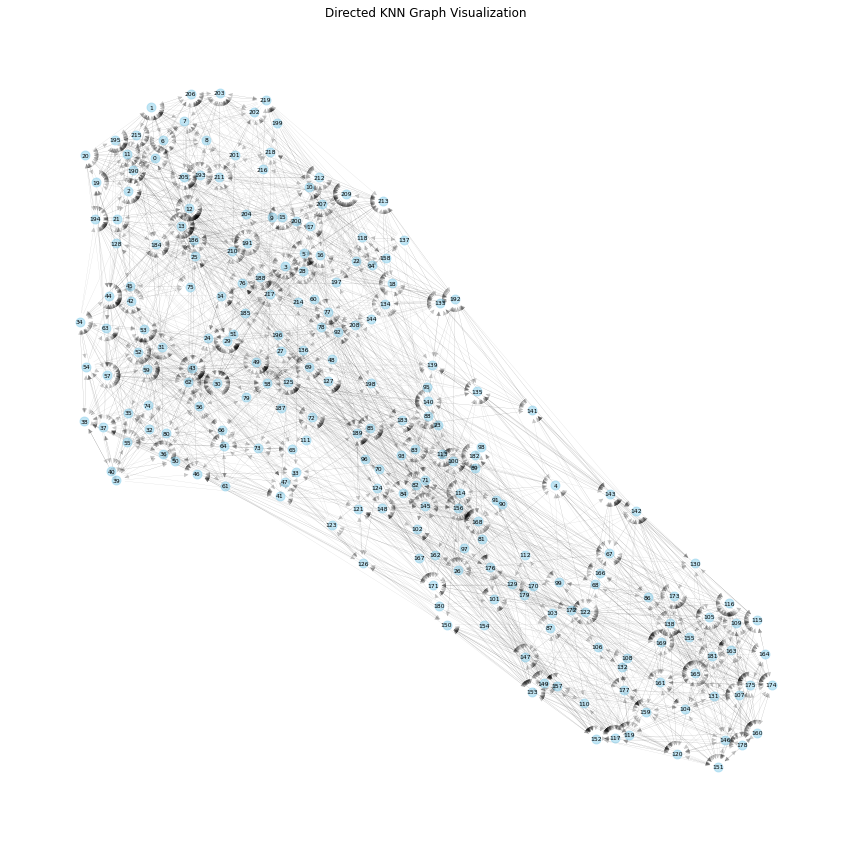

In [18]:
# 創建視覺化對象
knng_visualizer = KNNG_Visualizer(KNNG.B)

# 創建圖並繪製
graph = knng_visualizer.create_graph()
knng_visualizer.draw_graph(graph)

# Search nearest neighbor

In [19]:
import heapq
class Retriever():
  def __init__(self , B  , embedding_model , pool_max:int ):
    # Firstly , We obtain a K-Nearest Neighbors Graph .
    self.B        = B
    self.embedding_model = embedding_model
    self.l        = pool_max

  def __Cosine_Similarity__( self , vec1 , vec2 ) -> float:
    #we utilize cosine similarity to calculate the distance for two nodes of NLP task .
    dot_product = np.dot(vec1 , vec2 )
    norm_1   = np.linalg.norm(vec1)
    norm_2   = np.linalg.norm(vec2)
    similarity = dot_product / (norm_1 * norm_2)
    return similarity
  def __get_start_node__(self):
    return random.sample( [n for n in self.B.values()  ], 1 )[0]
  def InVoke( self , query:str , k:int = 1 )->list:
    """
    query : The object you want to compare against other nodes in the graph. The goal is to find the k-nearest neighbors of this object on a defined similarity metric .
    k   : number of nearest neighnbors.
    """
    query_vector = self.embedding_model.embed_query( query )
    candidates  = []
    visited    = set()

    #sampling start point p .
    start_node = self.__get_start_node__()

    #Initialize heap queue
    distance = self.__Cosine_Similarity__( query_vector ,start_node.vector )
    heapq.heappush(candidates , ( distance ,start_node ) ) # ( distance , node )

    # if len(candidates) + len(visited) > l => return top k node
    while (len(candidates) > 0 ) and ( ( len(visited)+len(candidates) ) < self.l ):
      # 1. get node from cindidates
      distance , node = heapq.heappop( candidates )

      if ( distance ,node ) in visited :
        continue

      visited.add((distance, node)) # ( distance , node )

      # Access node 's neighbor .
      for edge in node.out_edge:
        neighbor_node = self.B[ edge.to_node ]
        distance = self.__Cosine_Similarity__( query_vector ,neighbor_node.vector )
        if (distance ,neighbor_node) in candidates :
          continue


        heapq.heappush( candidates , ( distance , neighbor_node))# ( distance , node )

      # we need to truncate candidates

      candidates = heapq.nsmallest( self.l , candidates )

    # return top k nodes .

    combined = list(visited) + candidates
    print(f"combined length :{len(combined)}")
    combined = heapq.nlargest(k, combined)

    return [(distance , node) for distance, node in combined]

  def Compare_with_all( self , query:str , k:int = 1 )->list:
    query_vector = self.embedding_model.embed_query( query )
    candidates  = []
    for node in self.B.values() :
      distance = self.__Cosine_Similarity__( query_vector ,node.vector )
      heapq.heappush( candidates , ( distance , node))# ( distance , node )
    candidates = heapq.nlargest(k, candidates)

    return [(distance , node) for distance, node in candidates]







In [20]:
retrieve = Retriever(KNNG.B , hf_embeddings , int(len(KNNG.B) * 0.5) )

## Using Graph Search Algorithm

In [21]:
result = retrieve.InVoke( "What is KNNG ?" , k = 5 )
result

combined length :112


[(0.6533583376303478,
  id: 1 , content :35 Olden Street, Princeton, NJ 08540, USA
  ABSTRACT
  K-Nearest Neighbor Graph (K-NNG) construction is an im-
  portant operation with many web related applications, in-
  cluding collaborative ﬁltering, similarity search, and many , vector len :1024),
 (0.580590259945412,
  id: 12 , content :only practical for small datasets. Substantial eﬀort has been
  devoted in research related to K-NNG construction and K-
  NN search, and numerous methods have been developed,
  but existing methods either do not scale, or are speciﬁc to , vector len :1024),
 (0.5736932032892613,
  id: 135 , content :to reduce space cost, but could slightly raise scan rate to
  achieve the same recall. We make the following optimiza-
  tions to the original LSH method to better suit the K-NNG
  construction task: , vector len :1024),
 (0.5444806601186137,
  id: 184 , content :tion for general metric space as a primary problem (rather
  than an application of K-NN search me

## Comparing query with all nodes.

In [22]:
result_all = retrieve.Compare_with_all( "What is KNNG ?" , k = 5 )
result_all

[(0.6533583376303478,
  id: 1 , content :35 Olden Street, Princeton, NJ 08540, USA
  ABSTRACT
  K-Nearest Neighbor Graph (K-NNG) construction is an im-
  portant operation with many web related applications, in-
  cluding collaborative ﬁltering, similarity search, and many , vector len :1024),
 (0.635261520645782,
  id: 9 , content :K-NNG is also a key data structure for many established
  Copyright is held by the International W orld Wide W eb Conference Com-
  mittee (IW3C2). Distribution of these papers is limited to classroom use,
  and personal use by others. , vector len :1024),
 (0.6274874093421737,
  id: 11 , content :K-NNG construction method will enable the application of
  a large pool of existing graph and network analysis methods
  to datasets without an explicit graph structure.
  K-NNG construction by brute-force has cost O(n2) and is , vector len :1024),
 (0.6203368673826027,
  id: 6 , content :1. INTRODUCTION
  The K-Nearest Neighbor Graph (K-NNG) for a set of ob-
  je